<a href="https://colab.research.google.com/github/YoheiFukuhara/nlp100-2020/blob/main/09.RNN%2CCNN/89_%E4%BA%8B%E5%89%8D%E5%AD%A6%E7%BF%92%E6%B8%88%E3%81%BF%E8%A8%80%E8%AA%9E%E3%83%A2%E3%83%87%E3%83%AB%E3%81%8B%E3%82%89%E3%81%AE%E8%BB%A2%E7%A7%BB%E5%AD%A6%E7%BF%92.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

事前学習済み言語モデル（例えばBERTなど）を出発点として，ニュース記事見出しをカテゴリに分類するモデルを構築せよ．

In [1]:
!pip uninstall -q -y tensorflow-text tf-model-official
!pip install -q -U tensorflow-text tf-models-official

     |████████████████████████████████| 5.9 MB 15.9 MB/s 
     |████████████████████████████████| 2.2 MB 42.5 MB/s 
     |████████████████████████████████| 578.0 MB 15 kB/s 
     |████████████████████████████████| 5.9 MB 46.8 MB/s 
     |████████████████████████████████| 1.7 MB 50.0 MB/s 
     |████████████████████████████████| 438 kB 71.8 MB/s 
     |████████████████████████████████| 38.2 MB 223 kB/s 
     |████████████████████████████████| 352 kB 73.8 MB/s 
     |████████████████████████████████| 238 kB 74.8 MB/s 
     |████████████████████████████████| 1.3 MB 64.6 MB/s 
     |████████████████████████████████| 116 kB 47.3 MB/s 
     |████████████████████████████████| 636 kB 72.5 MB/s 
     |████████████████████████████████| 43 kB 2.1 MB/s 
     |████████████████████████████████| 99 kB 9.0 MB/s 
     |████████████████████████████████| 1.1 MB 60.7 MB/s 


In [2]:
from google.colab import drive
from official.nlp import optimization  # to create AdamW optimizer
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text # 明示的に使っていないが必要

drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!python --version
!pip show google tensorflow pandas tensorflow-text tf-models-official

Python 3.7.14
Name: numpy
Version: 1.21.6
Summary: NumPy is the fundamental package for array computing with Python.
Home-page: https://www.numpy.org
Author: Travis E. Oliphant et al.
Author-email: None
License: BSD
Location: /usr/local/lib/python3.7/dist-packages
Requires: 
Required-by: yellowbrick, xgboost, xarray, xarray-einstats, wordcloud, torchvision, torchtext, tifffile, thinc, tf-models-official, tensorflow, tensorflow-probability, tensorflow-model-optimization, tensorflow-hub, tensorflow-datasets, tensorboard, tables, statsmodels, spacy, sklearn-pandas, seqeval, seaborn, scs, scipy, scikit-learn, scikit-image, sacrebleu, resampy, qudida, qdldl, PyWavelets, python-louvain, pystan, pysndfile, pymc, pyerfa, pyemd, pycocotools, pyarrow, prophet, plotnine, patsy, pandas, osqp, opt-einsum, opencv-python, opencv-python-headless, opencv-contrib-python, numexpr, numba, nibabel, netCDF4, moviepy, mlxtend, mizani, missingno, matplotlib, matplotlib-venn, lightgbm, librosa, Keras-Preproces

In [4]:
BASE_PATH = '/content/drive/MyDrive/ColabNotebooks/ML/NLP100_2020/'

In [5]:
def read_dataset(type_):
    df = pd.read_table(BASE_PATH+'06.MachineLearning/'+type_+'.feature.txt')
    df.info()
    sr_title = df['title'].str.split().explode()
    y = df['category'].replace({'b':0, 't':1, 'e':2, 'm':3})
    return df['title'], tf.keras.utils.to_categorical(y, dtype='int32')  # 4値分類なので訓練・検証・テスト共通でone-hot化

In [6]:
%%time
X_train, y_train = read_dataset('train')
X_valid, y_valid = read_dataset('valid')
X_test, y_test = read_dataset('test')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10684 entries, 0 to 10683
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   title     10684 non-null  object
 1   category  10684 non-null  object
dtypes: object(2)
memory usage: 167.1+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1336 entries, 0 to 1335
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   title     1336 non-null   object
 1   category  1336 non-null   object
dtypes: object(2)
memory usage: 21.0+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1336 entries, 0 to 1335
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   title     1336 non-null   object
 1   category  1336 non-null   object
dtypes: object(2)
memory usage: 21.0+ KB
CPU times: user 89.4 ms, sys: 19.7 ms, total: 109 ms
Wall time: 4.9 s


In [7]:
preprocessor = hub.KerasLayer(
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
        name='preprocessor')

text_preprocessed = preprocessor([X_train[0]])

print(f'Text        : {[X_train[0]]}')
print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Text        : ['REFILE UPDATE car sale up for sixth month as economy recover']
Keys       : ['input_type_ids', 'input_word_ids', 'input_mask']
Shape      : (1, 128)
Word Ids   : [  101 25416  9463 10651  2482  5096  2039  2005  4369  3204  2004  4610]
Input Mask : [1 1 1 1 1 1 1 1 1 1 1 1]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


In [8]:
encoder = hub.KerasLayer(
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/2',
        trainable=True, name='BERT_encoder')
bert_results = encoder(text_preprocessed)

print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Pooled Outputs Shape:(1, 512)
Pooled Outputs Values:[ 0.83857816  0.8714344  -0.05869783 -0.21945992  0.14879902  0.62879145
  0.99516565 -0.9972128   0.15385738 -0.99931264  0.3135587  -0.8180948 ]
Sequence Outputs Shape:(1, 128, 512)
Sequence Outputs Values:[[ 0.33862212 -0.11791104  0.3418219  ... -1.1574944   0.29415578
   0.9472706 ]
 [ 0.28497177  0.39325225  0.60013586 ... -0.35047954  0.5410543
   1.267122  ]
 [-0.8773053   0.01777261  0.68712896 ...  0.60109943 -0.22280091
   1.305879  ]
 ...
 [ 0.00644314  0.17899063  0.6403154  ... -0.34970805  0.08075863
   0.14510325]
 [-0.33870348  0.36234245  0.05213176 ... -0.7976972  -0.43191314
   0.8580584 ]
 [-0.10936005  0.2492041   0.58715516 ...  0.34737933 -0.64347273
   0.71053106]]


In [9]:
def build_classifier_model(preprocessor, encoder):
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    encoder_inputs = preprocessor(text_input)
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output'] # [batch_size, 512].
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(4, activation='softmax', name='classifier')(net)
    return tf.keras.Model(text_input, net)    

model = build_classifier_model(preprocessor, encoder)
bert_raw_result = model(tf.constant([X_train[0]]))
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.5128579  0.56176686 0.63317573 0.5385126 ]], shape=(1, 4), dtype=float32)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 preprocessor (KerasLayer)      {'input_type_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                      

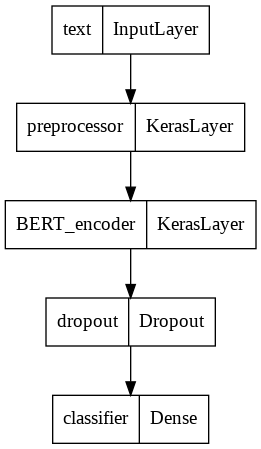

In [10]:
model.summary()

# show_shapes=True , then error
tf.keras.utils.plot_model(model)

In [11]:
epochs = 5
# train data 10684
# cardinality は データ件数/バッチサイズ を切り上げ
#steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
steps_per_epoch = (len(X_train)+32-1)//32 # 除算切り上げ
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

optimizer = optimization.create_optimizer(init_lr=3e-5,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['acc'])

In [12]:
%%time
model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=30,
          callbacks=[tf.keras.callbacks.EarlyStopping(
              patience=5, restore_best_weights=False)])

Epoch 1/30
334/334 [==============================] - 78s 217ms/step - loss: 0.6090 - acc: 0.7742 - val_loss: 0.3382 - val_acc: 0.8885
Epoch 2/30
334/334 [==============================] - 75s 225ms/step - loss: 0.2616 - acc: 0.9125 - val_loss: 0.2982 - val_acc: 0.9147
Epoch 3/30
334/334 [==============================] - 74s 221ms/step - loss: 0.1819 - acc: 0.9405 - val_loss: 0.3111 - val_acc: 0.9124
Epoch 4/30
334/334 [==============================] - 73s 219ms/step - loss: 0.1337 - acc: 0.9571 - val_loss: 0.3245 - val_acc: 0.9162
Epoch 5/30
334/334 [==============================] - 72s 216ms/step - loss: 0.0997 - acc: 0.9677 - val_loss: 0.3327 - val_acc: 0.9184
Epoch 6/30
334/334 [==============================] - 73s 219ms/step - loss: 0.0947 - acc: 0.9701 - val_loss: 0.3327 - val_acc: 0.9184
Epoch 7/30
334/334 [==============================] - 71s 214ms/step - loss: 0.0913 - acc: 0.9715 - val_loss: 0.3327 - val_acc: 0.9184
CPU times: user 7min 45s, sys: 48.4 s, total: 8min 33s


In [13]:
model.evaluate(X_test, y_test)

42/42 [==============================] - 4s 95ms/step - loss: 0.2419 - acc: 0.9259


[0.24186475574970245, 0.9258981943130493]